In [1]:
import awkward as ak
import numpy as np
import hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
DelphesSchema.mixins["FatJet"] = "Jet"

In [2]:
samples = [
    {"name": "CMS", "model": "s-channel_mmed-1000_Nc-2_Nf-2_scale-35.1539_mq-10_mpi-20_mrho-20_pvector-0.75_spectrum-cms_rinv-0.3"},
    {"name": "Snowmass", "model": "s-channel_mmed-1000_Nc-3_Nf-3_scale-10_mq-10.119_mpi-6_mrho-25.0998_pvector-0.5_spectrum-snowmass_rinv-0.777778"},
    {"name": "Snowmass_cmslike", "model": "s-channel_mmed-1000_Nc-3_Nf-3_scale-33.3333_mq-33.73_mpi-20_mrho-83.666_pvector-0.5_spectrum-snowmass_rinv-0.3"}
]

In [3]:
# load data and metadata
import sys
sys.path.append('..')

from svjHelper import svjHelper
for sample in samples:
    path = f'../models/{sample["model"]}'
    sample["helper"] = svjHelper.build(f'{path}/config.py')
    metadict = sample["helper"].metadata()
    metadict["dataset"] = sample["name"]
    sample["events"] = NanoEventsFactory.from_root(     #To load data
        file=f'{path}/events.root',
        treepath="Delphes",
        schemaclass=DelphesSchema,
        metadata=metadict,
    ).events()

In [5]:
(samples[0])["events"].fields

['EFlowNeutralHadron.offsets',
 'EFlowNeutralHadron',
 'Tower.offsets',
 'Tower',
 'MissingET.offsets',
 'MissingET',
 'ScalarHT.offsets',
 'ScalarHT',
 'Weight.offsets',
 'Weight',
 'Electron.offsets',
 'Electron',
 'Event.offsets',
 'Event',
 'FatJet.offsets',
 'FatJet',
 'EFlowTrack.offsets',
 'EFlowTrack',
 'GenMissingET.offsets',
 'GenMissingET',
 'Particle.offsets',
 'Particle',
 'Photon.offsets',
 'Photon',
 'EFlowPhoton.offsets',
 'EFlowPhoton',
 'Muon.offsets',
 'Muon',
 'Track.offsets',
 'Track',
 'GenFatJet.offsets',
 'GenFatJet',
 'Jet.offsets',
 'Jet',
 'GenJet.offsets',
 'GenJet']

In [ ]:
# Test for event[0]

dark_hadron_ids = [4900111, 4900113, 4900211, 4900213]
stable_particle_ids = [51, 52, 53]
    
# A list of indices of dark particle
dark_idx = []
for i in range(len(pid[0])):
    if(np.abs(pid[0][i]) in dark_hadron_ids or np.abs(pid[0][i]) in stable_particle_ids):
        dark_idx.append(i)
        print(f"PID[{i}]: {pid[0][i]}")
        
print(dark_idx)

In [ ]:
# Version 1 Only for CMS model

dark_hadron_ids = [4900111, 4900113, 4900211, 4900213]
stable_particle_ids = [51, 52, 53]

events = (samples[0])['events']
particles = events.Particle
PID = events.Particle["PID"]
d1 = events.Particle["D1"]
stable_inv_frac = [0]*len(events)
  
# for each event
for event in range(len(events)):
        
    # A list of indices of dark particle
    dark_idx = []
        
    # for each particle
    for i in range(len(PID[event])):
        if(np.abs(PID[event][i]) in dark_hadron_ids):
            dark_idx.append(i)
                
    count = 0
    for idx in dark_idx:
        if(PID[event][np.abs(d1[event][idx])] in stable_particle_ids):
            count+=1
        
    if(len(dark_idx)!=0):
        stable_inv_frac[event] = count/len(dark_idx)
            
        
# Add the invisible fraction to the events
events["stable_invisible_fraction"] = stable_inv_frac
print(f"Average stable_invivisble_fraction for CMS model = {np.sum(stable_inv_frac)/len(stable_inv_frac)}")
    
# store modified events array
(samples[0])["events"] = events

In [ ]:
# Version 2 For other models

dark_hadron_ids = [4900111, 4900211]
stable_particle_ids = [51, 52, 53]

for sample in samples[1:]:
    events = sample["events"]
    particles = events.Particle
    PID = events.Particle["PID"]
    d1 = events.Particle["D1"]
    stable_inv_frac = [0]*len(events)
    
    # for each event
    for event in range(len(events)):
        
        # A list of indices of dark particle
        dark_idx = []
        
        # for each particle
        
        # Making a list of indices with dark particles
        for i in range(len(PID[event])):
            if(np.abs(PID[event][i]) in dark_hadron_ids):
                dark_idx.append(i)
                
        count = 0
        for idx in dark_idx:
            if(PID[event][np.abs(d1[event][idx])] in stable_particle_ids):
                count+=1
        
        if(len(dark_idx)!=0):
            stable_inv_frac[event] = count/len(dark_idx)
        
    # Add the invisible fraction to the events
    events["stable_invisible_fraction"] = stable_inv_frac
    print(f"Average stable_invivisble_fraction for model {sample['name']} = {np.sum(stable_inv_frac)/len(stable_inv_frac)}")
    
    # store modified events array
    sample["events"] = events

In [ ]:
# version 2 **Don't run**
dark_hadron_ids = [4900111, 4900211]
stable_particle_ids = [51, 52, 53]

for sample in samples[1:]:
    events = sample["events"]
    particles = events.Particle
    PID = particles.PID
    d1 = particles.D1
    
    # Identify dark hadrons
    is_dark_hadron = ak.any(np.abs(PID)[:, :, None] == dark_hadron_ids, axis=-1)
    
    # Get indices of dark hadrons
    dark_hadron_indices = ak.local_index(is_dark_hadron)[is_dark_hadron]
    
    # Get the D1 daughters of dark hadrons
    dark_hadron_daughters = ak.ArrayBuilder()
    for event in d1:
        for idx in dark_hadron_indices[event]:
            dark_hadron_daughters.append(event[idx])
    
    dark_hadron_daughters = dark_hadron_daughters.snapshot()
    
    # Identify stable invisible particles among the daughters
    is_stable_invisible = ak.any(np.abs(PID[:, dark_hadron_daughters]) == stable_particle_ids, axis=-1)
    
    # Calculate the per-event stable invisible fraction
    dark_hadron_counts = ak.sum(is_dark_hadron, axis=1)
    stable_invisible_counts = ak.sum(is_stable_invisible, axis=1)
    stable_invisible_fraction = ak.where(dark_hadron_counts > 0, stable_invisible_counts / dark_hadron_counts, 0)
    
    # Add the invisible fraction to the events
    events["stable_invisible_fraction"] = stable_invisible_fraction
    
    # Print the average stable invisible fraction for verification
    print(f"Average stable_invisible_fraction for model {sample['name']} = {np.mean(stable_invisible_fraction)}")
    
    # Store modified events array
    sample["events"] = events

In [ ]:
# Version 3

# Mock data
mock_pid = ak.Array([
    [1,2,3,4,5,6,7,8,9,0], # 3-unstable, 6-stable, 9-stable
    [1,3,5,7,9,0], #3-stable, 9-unstable
    [3,6,9,0] # 3-unstable, 6-stable, 9-stable
])
mock_d1 = ak.Array([
    [1,2,5,4,5,7,7,8,9,0], 
    [1,5,3,4,1,0],
    [1,3,3,0]
])
mock_dark = [3,6,9]
mock_stable = [8,0]

# Indices that contain dark particle
mock_dark_index = ak.local_index(mock_pid)[ak.any(mock_pid[:,:,None]==mock_dark,axis=-1)]
print(mock_dark_index)

# PIDs of dark daughter
dark_daughter = mock_pid[mock_d1[mock_dark_index]]
print(dark_daughter)
 
Stability = []
for event in range(len(mock_pid)):
    
    # Reshaping dark daughter array to match the shape of mock_stable
    dark_daughter_=ak.Array([dark_daughter[event]]*len(mock_stable))
    
    # Total stable dark per event
    n_stable = np.sum((dark_daughter_==mock_stable)[0]+(dark_daughter_==mock_stable)[1])
    #print(n_stable)
    
    # Fraction
    Stability.append(n_stable/len(mock_dark_index[event]))

Stability

In [ ]:
# Version 4 on mock data

# Mock data
mock_pid = ak.Array([
    [1,2,3,4,5,6,7,8,9,0], # 3-unstable, 6-stable, 9-stable
    [1,3,5,7,9,0], #3-stable, 9-unstable
    [3,6,9,0] # 3-unstable, 6-stable, 9-stable
])
mock_d1 = ak.Array([
    [1,2,5,4,5,7,7,8,9,0], 
    [1,5,3,4,1,0],
    [1,3,3,0]
])
mock_dark = [3,6,9]
mock_stable = [8,0]

# If the element is a dark particle
is_dark = ak.any(mock_pid[:,:,None]==mock_dark,axis=-1)

# PIDs of dark daughter
dark_daughter = mock_pid[mock_d1[is_dark]]

# Reshaping mock_stable to match the shape of dark daughter array
for i in range(len(dark_daughter)-len(mock_stable)):
    mock_stable.append(mock_stable[-1])
    
# print(dark_daughter, mock_stable)
 
stability=ak.sum(ak.any(dark_daughter[:,:,None]==mock_stable,axis=-1),axis=1)/ak.sum(is_dark,axis=1)
stability

In [ ]:
# Version 5 Only for CMS model

dark_hadron_ids = [4900111, 4900113, 4900211, 4900213]
stable_particle_ids = [51, 52, 53]

events = (samples[0])['events']
pid = events.Particle["PID"][:10]
d1 = events.Particle["D1"][:10]

# Reshaping dark_hadron_ids to match the shape of PID
for i in range(len(pid)-len(dark_hadron_ids)):
    dark_hadron_ids.append(dark_hadron_ids[-1])
    
# If the element is a dark particle
is_dark = ak.any(np.abs(pid[:,:,None]) == dark_hadron_ids, axis=-1)

# PIDs of dark daughter
dark_daughter = pid[d1[is_dark]]

# Reshaping stable_particle_ids to match the shape of dark daughter array
for i in range(len(dark_daughter)-len(stable_particle_ids)):
    stable_particle_ids.append(stable_particle_ids[-1])
    
stability = ak.sum(ak.any(np.abs(dark_daughter[:,:,None])==stable_particle_ids,axis=-1),axis=1)/ak.sum(is_dark,axis=1)

# Add the invisible fraction to the events
#events["stable_invisible_fraction_cms"] = stability
    
# store modified events array
# (samples[0])["events"] = events
    
np.mean(stability)        

# Final Version

In [146]:
# Version 6 for cms model (Kevin is a genius!!)

dark_hadron_ids = [4900111, 4900113, 4900211, 4900213]
stable_particle_ids = [51, 52, 53]
events = (samples[0])['events']
pid = events.Particle["PID"]
d1 = events.Particle["D1"]

# Boolean array of whether a particle is dark
is_dark = ak.zeros_like(pid)
for dhid in dark_hadron_ids:
    is_dark = is_dark | (np.abs(pid)==dhid)
is_dark = is_dark==1
    
# PIDs of dark daughter
dark_daughter = pid[d1[is_dark]] 
is_dark_daughter = ak.zeros_like(dark_daughter)

for dsid in stable_particle_ids:
    is_dark_daughter = is_dark_daughter | (np.abs(dark_daughter)==dsid)
    
stability = [None]*len(events)
for i in range(len(pid)): 
    if ak.sum(is_dark[i])!=0:
        stability[i] = ak.sum(is_dark_daughter[i])/ak.sum(is_dark[i])
        
#stability = [ak.sum(is_dark_daughter[i])/ak.sum(is_dark[i]) for i in range(len(pid)) if ak.sum(is_dark[i])!=0]

# Add the invisible fraction to the events
events["stable_invisible_fraction"] = stability
    
# store modified events array
(samples[0])["events"] = events

#print(f"Average stable_invivisble_fraction for {(samples[0])['name']} model = {np.mean(ak.drop_none(stability))}")

# Final Version

In [147]:
# Version 6 for other models
dark_hadron_ids = [4900111, 4900211]
stable_particle_ids = [51, 52, 53]

for sample in samples[1:]:
    events = sample["events"]
    pid = events.Particle["PID"]
    d1 = events.Particle["D1"]
    
    # Boolean array of whether a particle is dark
    is_dark = ak.zeros_like(pid)
    for dhid in dark_hadron_ids:
        is_dark = is_dark | (np.abs(pid)==dhid)
    is_dark = is_dark==1
    
    # PIDs of dark daughter
    dark_daughter = pid[d1[is_dark]] 
    is_dark_daughter = ak.zeros_like(dark_daughter)

    for dsid in stable_particle_ids:
        is_dark_daughter = is_dark_daughter | (np.abs(dark_daughter)==dsid)
    
    #stability = [ak.sum(is_dark_daughter[i])/ak.sum(is_dark[i]) for i in range(len(pid)) if ak.sum(is_dark[i])!=0]
    stability = [None]*len(events)
    for i in range(len(pid)): 
        if ak.sum(is_dark[i])!=0:
            stability[i] = ak.sum(is_dark_daughter[i])/ak.sum(is_dark[i])
    
    # Add the invisible fraction to the events
    events["stable_invisible_fraction"] = stability

    #print(f"Average stable_invivisble_fraction for {sample['name']} model = {np.mean(stability)}")
    
    # store modified events array
    sample["events"] = events

> Average stable_invivisble_fraction for CMS model = 0.3012518045952696
  Average stable_invivisble_fraction for Snowmass model = 0.7741818392531269
  Average stable_invivisble_fraction for Snowmass_cmslike model = 0.3023673273161503

In [ ]:
## Diagnosis

# Mock data
mock_pid = ak.Array([
    [1,2,3,4,5,6,7,8,9,0], # 3-unstable, 6-stable, 9-stable
    [1,3,5,7,9,0], #3-stable, 9-unstable
    [3,6,9,0] # 3-unstable, 6-stable, 9-stable
])
mock_d1 = ak.Array([
    [1,2,5,4,5,7,7,8,9,0], 
    [1,5,3,4,1,0],
    [1,3,3,0]
])
mock_dark = [3,6,9]
mock_stable = [8,0]

is_dark = ak.zeros_like(mock_pid)
for dhid in mock_dark:
    is_dark = is_dark | (np.abs(mock_pid)==dhid)
is_dark = is_dark==1
print(is_dark)
    
dark_daughter = mock_pid[mock_d1[is_dark]] 
print(dark_daughter)
is_dark_daughter = ak.zeros_like(dark_daughter)
print(is_dark_daughter)

In [ ]:
print(particles.fields)

In [153]:
# helper functions to fill histograms

def get_values(var,sample):
    return ak.flatten(sample["events"][var],axis=None)

def fill_hist(var,nbins,bmin,bmax,label,samples):
    hists = {}
    for sample in samples:
        h = (
            hist.Hist.new
            .Reg(nbins, bmin, bmax, label=label)
            .Double()
        )
        h.fill(get_values(var,sample),weight=0.5)
        hists[sample["name"]] = h
    return hists

In [154]:
# stylistic options

mpl.rcParams.update({
    "axes.labelsize" : 18,
    "legend.fontsize" : 16,
    "xtick.labelsize" : 14,
    "ytick.labelsize" : 14,
    "font.size" : 18,
    "legend.frameon": True,
})
# based on https://github.com/mpetroff/accessible-color-cycles
# red, blue, mauve, orange, purple, gray, 
colors = ["#e42536", "#5790fc", "#964a8b", "#f89c20", "#7a21dd", "#9c9ca1"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

In [1]:
# helper to make a plot

def make_plot(hname,hists):
    fig, ax = plt.subplots(figsize=(8,6))
    for l,h in hists.items():
        hep.histplot(h,density=True,ax=ax,label=l)
    ax.set_xlim(h.axes[0].edges[0],h.axes[0].edges[-1])
    ax.set_yscale("log")
    ax.set_ylabel("Arbitury unit")
    ax.legend(framealpha=0.5)
    plt.savefig('../Histograms/{}.pdf'.format(hname),bbox_inches='tight')

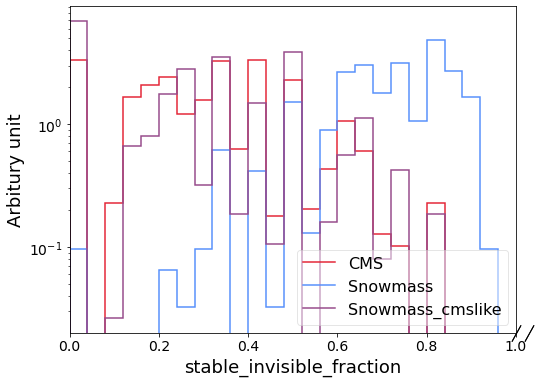

In [156]:
# plot invisible fraction
hists_if = fill_hist("stable_invisible_fraction",25,0,1,r"stable_invisible_fraction",samples)
make_plot("stable_invisible_fraction",hists_if)